# DeFactify 📰 - Iteration 1

This notebook is dedicated to developing a `Fake News Detection system` using machine learning techniques.

Let's begin by importing the libraries and checking their versions.

In [308]:
import nltk
import numpy
import pandas
import sklearn
import seaborn

import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn import preprocessing

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Library versions:")
print("- nltk:", nltk.__version__)              # 3.9.1
print("- numpy:", numpy.__version__)            # 2.1.3
print("- pandas:", pandas.__version__)          # 2.2.3
print("- sklearn:", sklearn.__version__)        # 1.6.1
print("- seaborn:", seaborn.__version__)        # 0.13.2


Library versions:
- nltk: 3.9.1
- numpy: 2.1.3
- pandas: 2.2.3
- sklearn: 1.6.1
- seaborn: 0.13.2


## Data provisioning 📦
Let's start by loading all the CSV files containing the articles. We will begin with the BBC data, which I scraped from each day as indicated by the file names. I was unable to find any pages on the BBC with multiple pages; all the content comes from the main page.

### Real News ✅ 

In [309]:
bbc1 = pandas.read_csv('scraper/dataset/bbc_23.03.25_real.csv')
bbc1.shape

(36, 8)

In [310]:
bbc2 = pandas.read_csv('scraper/dataset/bbc_24.03.25_real.csv')
bbc2.shape

(38, 8)

In [311]:
bbc3 = pandas.read_csv('scraper/dataset/bbc_27.03.25_real.csv')
bbc3.shape

(38, 8)

In [312]:
bbc4 = pandas.read_csv('scraper/dataset/bbc_31.03.25_real.csv')
bbc4.shape

(38, 8)

In [313]:
bbc5 = pandas.read_csv('scraper/dataset/bbc_06.04.25_real.csv')
bbc5.shape

(41, 8)

In [314]:
bbc6 = pandas.read_csv('scraper/dataset/bbc_07.04.25_real.csv')
bbc6.shape

(40, 8)

In [315]:
ap = pandas.read_csv('scraper/dataset/apnews_real.csv', encoding='latin1')
ap.shape

(240, 8)

### Fake News ❌

In [316]:
onion = pandas.read_csv('scraper/dataset/the_onion_fake.csv')
onion.shape

(130, 8)

In [317]:
spacexmania = pandas.read_csv('scraper/dataset/spacexmania_fake.csv', encoding='latin1')
spacexmania.shape

(149, 8)

In [318]:
peoples_voice = pandas.read_csv('scraper/dataset/peoples_voice_fake.csv')
peoples_voice.shape

(100, 8)

In [319]:
intel_drop = pandas.read_csv('scraper/dataset/intel_drop_fake.csv', encoding='latin1')
intel_drop.shape

(102, 8)

### Combination of all CSV files 📥

In [320]:
combined_dataset = pandas.concat([bbc1, bbc2, bbc3, bbc4, bbc5, bbc6, onion, spacexmania, peoples_voice, intel_drop, ap])
combined_dataset.shape

(952, 8)

## Sample the data 📃

In [321]:
combined_dataset.sample(10)

,Title,URL,Source,Journalist(s),Published Date,Content,Category,Label
133,Michael Jordan Leaves âWOKEâ California an...,https://spacexmania.com/michael-jordan-leaves-...,SpaceXMania,Alex Bruno,3-11-24,"In a surprising twist, basketball legend Micha...",World News,0
7,Trump envoy dismisses Starmer plan for Ukraine,https://www.bbc.com/news/articles/c62zm4eqvp7o,BBC,James Landale,23-03-25,Sir Keir Starmer's plan for an international f...,Politics,1
88,"Hawks fire GM Fields, promote Saleh to that ro...",https://apnews.com/newsletter/ground-game/apri...,AP News,Tim Reynolds,4/21/2025,Landry Fields was fired as general manager of ...,Sports,1
35,'Tinkering Hovland's pursuit of perfection pay...,https://www.bbc.com/sport/golf/articles/cvg1y2...,BBC,Iain Carter,24-03-25,Hovland's victory was his seventh on the PGA T...,Sports,1
57,Elon Musk Set to Acquire ABC and Name Tucker C...,https://spacexmania.com/elon-musk-set-to-acqui...,SpaceXMania,Alex Bruno,27-12-24,In a bold move that has sent shockwaves throug...,Politics,0
141,Elon Musk Reportedly Eyeing CNN Acquisition: â...,https://spacexmania.com/elon-musk-reportedly-e...,SpaceXMania,Alex Bruno,18-10-24,"In what might be his boldest move yet, Elon Mu...",Politics,0
80,Sharon Lokedi breaks Boston Marathon course re...,https://apnews.com/newsletter/ground-game/apri...,AP News,Jimmy Golen,4/21/2025,BOSTON (AP) â Sharon Lokedi broke the Boston...,Sports,1
91,"America, Trump, and the World: A New Isolationism",https://www.theinteldrop.org/2025/04/06/americ...,The Intel Drop,Dr. Farid Al-Khazen,6/4/2025,Dr. Farid Al-Khazen* 2025-04-06 Beirutâ The ...,Politics,0
49,Jim Caviezel and Mel Gibson Turn Down $500 Mil...,https://spacexmania.com/jim-caviezel-and-mel-g...,SpaceXMania,Alex Bruno,28-12-24,"Jim Caviezel and Mel Gibson, two Hollywood sta...",Entertainment,0
94,Rob Reiner Plans to Leave the U.S. After $50 M...,https://spacexmania.com/rob-reiner-plans-to-le...,SpaceXMania,Alex Bruno,11-12-24,"Rob Reiner, the veteran actor and director, ha...",Entertainment,0


## Preprocessing 🛠️

Before training the algorithm, it is essential to ensure that the dataset is clean and free of any issues. 

We can achieve this by checking for any rows that contain missing data and if we find any, we decide to remove them or not.

In [322]:
combined_dataset.isnull().sum()

Title               0
URL                 0
Source              0
Journalist(s)     245
Published Date     19
Content            39
Category            4
Label               0
dtype: int64

In this case, it is acceptable not to have any listed journalists, as it is common for fake news articles to lack authors. The absence of a publication date is also not a significant issue. However, the content is a key aspect we will analyse, so when either the content or the category is missing, we can discard those rows of data.

In [323]:
cleaned_dataset = combined_dataset.dropna(subset=['Content', 'Category'])

cleaned_dataset.shape

(913, 8)

It would be helpful to check for duplicated news titles, as I have noticed that some titles reappear multiple times. This way, we can remove them.

In [324]:
duplicate_titles = cleaned_dataset[cleaned_dataset.duplicated(subset=['Title'], keep=False)]

print(f"Number of duplicated titles: {duplicate_titles.shape[0]}")

Number of duplicated titles: 142


In [325]:
cleaned_dataset = cleaned_dataset.drop_duplicates(subset=['Title'], keep='first')

cleaned_dataset.shape

(840, 8)

In this iteration, I personally scraped the data, so I am familiar with most of the column information. However, to ensure everything is accurate, I am conducting a final check to confirm that the data contains only 0s and 1s. Overall, the data appears to be evenly distributed between fake and real news.

In [326]:
group_info = cleaned_dataset.groupby(["Label"])["Label"].count()
group_info

Label
0    456
1    384
Name: Label, dtype: int64

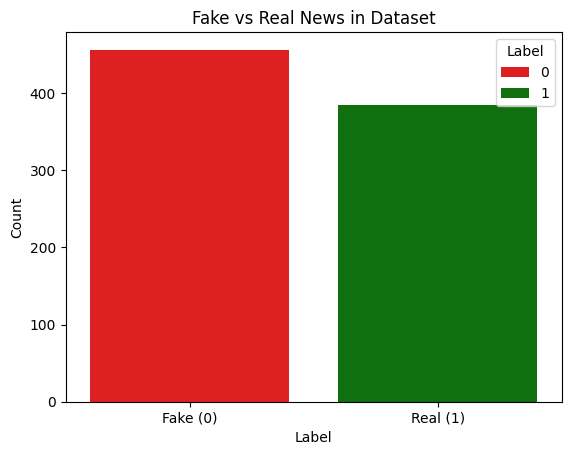

In [327]:
plt.figure()
seaborn.countplot(
    data=cleaned_dataset,
    x='Label',
    hue='Label', 
    palette={0: 'red', 1: 'green'},
)
plt.title('Fake vs Real News in Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Fake (0)', 'Real (1)'])
plt.show()


Since machine learning algorithms operate exclusively with numerical data and generate numerical outputs, the first step is to ensure that the target variable is numeric. Therefore, we need to convert the `Category` variable into numbers, but first let's visualise the categories and see how much we have from each.

In [328]:
category_counts = cleaned_dataset['Category'].value_counts()

category_table = category_counts.reset_index()
category_table.columns = ['Category', 'Count']

print(category_table)

         Category  Count
0        Politics    302
1   Entertainment    119
2          Sports    116
3      World News     80
4         Science     72
5         Economy     63
6  Human Interest     27
7           Crime     24
8     Environment     23
9      Technology     14


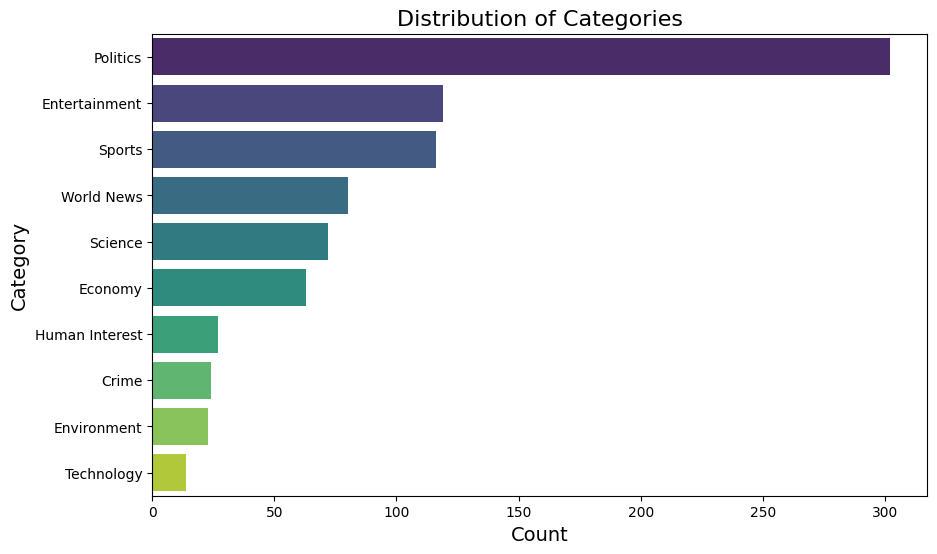

In [329]:
plt.figure(figsize=(10, 6))
seaborn.barplot(
    data=category_table,
    x='Count',
    y='Category',
    hue='Category', 
    palette='viridis'
)

plt.title('Distribution of Categories', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Category', fontsize=14)
plt.show()

In [330]:
encoder = preprocessing.LabelEncoder()

cleaned_dataset.loc[:, "Category"] = encoder.fit_transform(cleaned_dataset["Category"])

cleaned_dataset.sample(10)

,Title,URL,Source,Journalist(s),Published Date,Content,Category,Label
51,Trumpâs transactional approach to diplomacy ...,https://apnews.com/article/trump-transactional...,AP News,Aamer Madhani,3/9/2025,"WASHINGTON (AP) âDonald Trump, the real esta...",5,1
11,Rome: Thousands Protest EU’s Rearmament Plan,https://thepeoplesvoice.tv/rome-thousands-prot...,The People's Voice,Niamh Harris,6/4/2025,Huge numbers of demonstrators took to the stre...,5,0
58,Donald Trump doesnât want to commit suicide,https://www.theinteldrop.org/2025/04/08/donald...,The Intel Drop,Nehme Hamieh,8/4/2025,"Nehme Hamieh. April 08, 2025 Washington â Be...",5,0
13,Trump Orders Resumption of Border Wall Constru...,https://spacexmania.com/trump-orders-resumptio...,SpaceXMania,Alex Bruno,27-01-25,In a move guaranteed to ignite both fireworks ...,5,0
78,NFL Bans Taylor Swift from Attending Chiefs Ga...,https://spacexmania.com/nfl-bans-taylor-swift-...,SpaceXMania,Alex Bruno,14-12-24,"In a surprising turn of events, the NFL has an...",7,0
10,FEMA Chief Deanne Criswell Fired After Insensi...,https://spacexmania.com/fema-chief-deanne-cris...,SpaceXMania,Alex Bruno,2-02-25,"In a shocking turn of events, Deanne Criswell,...",5,0
184,Crocodile attacks in Indonesia are on the rise...,https://apnews.com/newsletter/ground-game/apri...,AP News,NaN,3/17/2025,"BUDONG-BUDONG, Indonesia (AP) â Nearly seven...",6,1
54,Republicans once railed against armed IRS agen...,https://apnews.com/article/armed-irs-agents-im...,AP News,Fatima Hussein,2/12/2025,"WASHINGTON (AP) â For years, Republicans, in...",5,1
11,South Korea court reinstates PM as acting leader,https://www.bbc.com/news/articles/c625jkyrx6do,BBC,Tessa Wong,24-03-25,South Korea's constitutional court has dismiss...,5,1
43,Sony Music Removes Madonna from Studio Over Pr...,https://spacexmania.com/sony-music-removes-mad...,SpaceXMania,Alex Bruno,29-12-24,The entertainment industry has long been a spa...,2,0


### Stopwords 🛑
Stopwords are the most commonly used words in a language, such as "in," "on," "a," "an," and "the" in English. 
When evaluating whether an article is fake or not, we do not need these words, so we can choose to remove them.

In [331]:
stemmer = PorterStemmer()

stop_words = set(stopwords.words('English'))

print(stopwords.words('English'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

### Stemming 🌱

Stemming is a technique that helps algorithms function more effectively. It reduces words to their root form. For instance, the words "programming" "programmer" and "programs" can all be reduced to the common word stem "program."

In [332]:
stemmer = PorterStemmer()

stop_words = set(stopwords.words('English'))

def preprocess_and_stem(text):
    # tokenize the text, convert to lowercase and remove punctuation
    tokens = word_tokenize(text.lower())
    # remove stopwords and apply stemming
    stemmed_tokens = [stemmer.stem(word) for word in tokens if word.isalnum() and word not in stop_words]

    return ' '.join(stemmed_tokens)

In [333]:
cleaned_dataset['Title'] = cleaned_dataset['Title'].astype(str).apply(preprocess_and_stem)
cleaned_dataset['Content'] = cleaned_dataset['Content'].astype(str).apply(preprocess_and_stem)

print(cleaned_dataset[['Title', 'Content']].head())

                                               Title  \
0     istanbul mayor arrest ahead select run erdogan   
1    kill gaza sinc israel offens began ministri say   
2              ferrari hamilton disqualifi chines gp   
3            life spent wait search row unclaim bodi   
5  us hope progress peac talk three kill russian ...   

                                             Content  
0  main rival turkey presid recep tayyip erdogan ...  
1  palestinian kill israel militari campaign gaza...  
2  lewi hamilton finish sixth chines grand prix s...  
3  saira baloch 15 step morgu first time heard ro...  
5  imogen jamesl report upcom peac talk ukrain wa...  


### Word Cloud ☁️
Let's visualise the most used words in both fake and real media, when it comes to the `Title` and `Content` of the news.

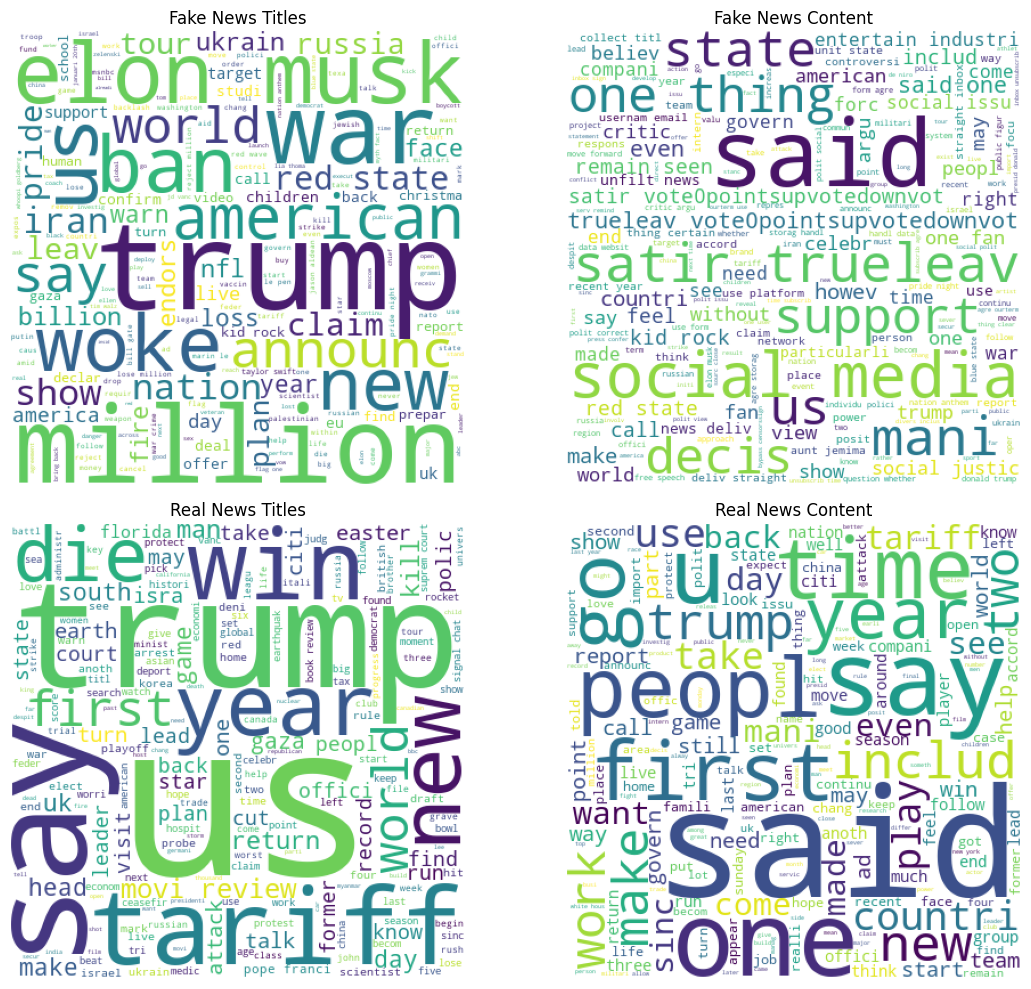

In [334]:
real_titles = ' '.join(cleaned_dataset[cleaned_dataset['Label'] == 1]['Title'])
fake_titles = ' '.join(cleaned_dataset[cleaned_dataset['Label'] == 0]['Title'])

real_content = ' '.join(cleaned_dataset[cleaned_dataset['Label'] == 1]['Content'])
fake_content = ' '.join(cleaned_dataset[cleaned_dataset['Label'] == 0]['Content'])

fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# titles comparison
ax[0, 0].imshow(WordCloud(width=400, height=400, background_color='white').generate(fake_titles))
ax[0, 0].set_title("Fake News Titles")
ax[0, 0].axis('off')

ax[1, 0].imshow(WordCloud(width=400, height=400, background_color='white').generate(real_titles))
ax[1, 0].set_title("Real News Titles")
ax[1, 0].axis('off')

# content comparison
ax[1, 1].imshow(WordCloud(width=400, height=400, background_color='white').generate(real_content))
ax[1, 1].set_title("Real News Content")
ax[1, 1].axis('off')

ax[0, 1].imshow(WordCloud(width=400, height=400, background_color='white').generate(fake_content))
ax[0, 1].set_title("Fake News Content")
ax[0, 1].axis('off')

plt.tight_layout()
plt.show()

In comparison to Iteration 0, we can see more recent words that appear in current media, such as "tariff" and "Trump"; there is no mention of "Hillary Clinton" anymore. To summarize:

| **News**   | **Titles**                                                                                          | **Content**                                                                                          |
|-----------------|----------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------|
| **Fake**   | Big, dramatic words like "million", "war" and "woke" and names of famous people like "Trump", "Elon" and "Musk". | Focus on opinions, social media and words like "support", "satire" and "true". Less about facts, more about feelings or controversy. |
| **Real**   | Words about real events and places like "kill", "win", "Gaza", "Ukraine", "tariff" and "Trump". More factual and direct. | Focus on people, facts and explanations. Common words are "one", "people", "say", "year" and "country." More neutral and informative. |


### Converting the textual data to numerical data 🔁

TF-IDF (Term Frequency-Inverse Document Frequency) is used to convert textual data into numerical features, allowing machine learning models like K-NN and Naive Bayes to process it. It assigns weights to words based on their frequency in a document and their rarity across the dataset, highlighting important terms. The `TfidfVectorizer` transforms the cleaned text data into a numerical array, which is used as the input features (X). The target labels (y), already numerical, represent the classification of each text as real (1) or fake (0).

In [335]:
vectorizer_title = TfidfVectorizer()
vectorizer_content = TfidfVectorizer()

X_title = vectorizer_title.fit_transform(cleaned_dataset['Title']).toarray()
X_content = vectorizer_content.fit_transform(cleaned_dataset['Content']).toarray()

print("Title TF-IDF shape:", X_title.shape)
print("Content TF-IDF shape:", X_content.shape)

Title TF-IDF shape: (840, 2902)
Content TF-IDF shape: (840, 20651)


### Combine the features 🥣
Combine the title and content into one feature matrix.

In [336]:
X = numpy.hstack((X_title, X_content))

### Target variable 🎯 
The target variable is obviously `Label`.

In [337]:
y = cleaned_dataset['Label']

### Splitting into train/test 🪓

We will use 80% of the data for training and the rest - 20% for testing.

In [338]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("There are in total", len(y), "observations, of which", len(X_train), "are now in the train set and", len(X_test), "in the test set.")

There are in total 840 observations, of which 672 are now in the train set and 168 in the test set.


### Modelling 🧬

For iteration 0, I used K-NN for iteration 0 and now, for Iteration 1 - Naive Bayes. The test set will be used to calculate the model's accuracy, which indicates how well it performs.

In [339]:
clf = MultinomialNB()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [340]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Naive Bayes: {accuracy * 100:.2f}%")

Accuracy of Naive Bayes: 88.10%


The accuracy of Naive Bayes is approximately 88%, which is higher than K-NN - 65%.

## Evaluation 🔬

This report evaluates the accuracy of recognising news as fake or real and assesses the model's performance.

In [341]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90        92
           1       1.00      0.74      0.85        76

    accuracy                           0.88       168
   macro avg       0.91      0.87      0.88       168
weighted avg       0.90      0.88      0.88       168



It is important to consider the confusion matrix when evaluating a model's performance. The overall accuracy of the model is 88%. However, the recall for "Real" is at nearly 100%, indicating that the model correctly identifies most real cases.

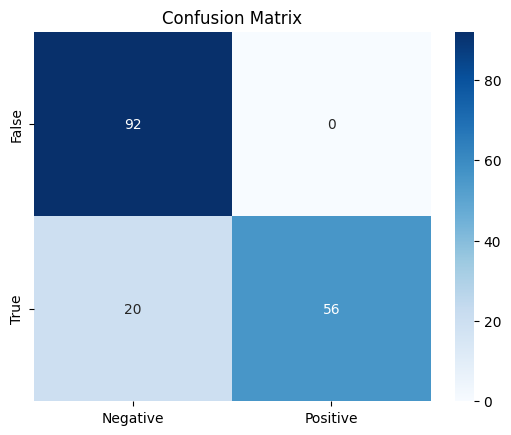

In [342]:
cm = confusion_matrix(y_test, y_pred)

seaborn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['False', 'True'])
plt.title('Confusion Matrix')
plt.show()